# Loan Default Binary Classification using Neural Networks & mini batch Stochastic Gradient Descent implemented using Numpy

## Table of Contents
* [1. Introduction](#Deep_neural)

* [2. Implementation of the neural network with mini batch Stochastic Gradient Descent](#Implementation)

* [3. Loan Default dataset & One Hot Encoding](#Loan_default)

* [4. Prepping the train test sets](#train_test)    
    
* [5. Implemented Logistic Regression Model](#imp_log_reg)
    
* [6. Neural Network with Traditional Gradient Descent](#trad_NN)

* [7. Training the Neural Network with mini batch Stochastic Gradient Descent](#SGD_NN)

* [8. Comparison of Convergence -  Gradient Descent vs. Stochastic Gradient Descent](#comparison)

* [9. Scikit Learn's Logistic Regression Classifier](#sklearn_logreg)

* [10. The ROC metric](#roc)

## 1. Introduction <a class="anchor" id="Deep_neural"></a>

Stochastic gradient descent (SGD) is a popular algorithm used for finding the weights and bias arrays which minimize the cost function in a neural network's training process. Most of the modern deep learning frameworks (TensorFlow,PyTorch) use advanced optimization methods like Adam, RMSprop which are based on SGD. In this notebook a vanilla mini batch SGD has been implemented and used for predicting loan default probabilies using the <a href="https://www.kaggle.com/wendykan/lending-club-loan-data">Lending Club Loan Default Dataset</a>. The Lending Club dataset is quite large (over 2 GB) with many features. <a href="https://arunj2014.netlify.app/blog/loan_default_notebook_prt1/">My personal R Blogdown site</a> covers the exploratory data analysis and the simplification of the dataset in great detail. A reduced dataset with around 40000 rows and 58 features was used in this study to validate the implementation of mini batch Stochastic Gradient descent. The details about deep learning neural network implementation is described in this <a href="https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Deep%20Neural%20Network%20Gradient%20Descent/Dense_neural_network_many_layers.ipynb">notebook</a> along with validation on the breast cancer dataset. The previous implementation used a traditional gradient descent algorithm which is susceptible to getting stuck in a local minima. In mini batch SGD, the training dataset with m training examples is randomly split into many small batches of size k where $0<k<m$  at each epoch and the weights are trained on these batches (X_train_batch and y_train_batch) sequentially. The cost function is calculated based on m training samples and displayed. The random shuffles of the dataset prevents the gradient descent from getting stuck in any local minima.
Ref. <a href="https://sebastianraschka.com/books.htmlRashka"> Python Machine Learning, 3rd Edition Raschka</a>. SGD speeds up the convergence of the cost function minimization quite a bit.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nn_trad import dense_NN
from logreg import logregmodel
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
%matplotlib inline

## 2. Implementation of the neural network with mini batch Stochastic Gradient Descent <a class="anchor" id="Implementation"></a>

Please refer to the full implementation of a 
<a href =https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Deep%20Neural%20Network%20Gradient%20Descent/Dense_neural_network_many_layers.ipynb> Feed forward neural network with the traditional gradient descent algorithm here.</a> The following class adds the mini batch Stochastic gradient descent optimization algorithm to the class.

In [3]:
class dense_NN_sgd():
    def __init__(self,seed=10):        
        self.nn_struct={}
        self.index = int(0)
        self.W = {}
        self.b = {}
        self.Z = {}
        self.A = {}
        self.dA = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        #self.cost = []
        self.cost_list=np.array([])
        self.random = np.random.RandomState(seed)
    
    ###################Scaler###################
    def scaler_fit(self,X):
        self.X_max = X.max(0)
        self.X_min = X.min(0)
            
    def scaler_transform(self,X):
        return (X-self.X_min)/(self.X_max-self.X_min)
    
    ############################################
    
    #################Activation functions & derivatives###################
    ############Activation Functions############
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def RELU(self,x):
        return np.maximum(0,x)
    
    def tanh(self,x):
        return np.tanh(x)
    
    def leakyRELU(self,x):
        return np.maximum(0.01*x,x)
    
    #############Derivatives#####################
    def dsigmoid(self,X):
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    def dRELU(self,x):
        return np.where(x>=0.0,1,0)   
    
    def dtanh(self,X):
        return (1-np.square(np.tanh(X)))
    
    def dleakyRELU(self,x):
        return np.where(x>=0,0.01,1.0)
    
    ##############################################
    
    def g(self,X,fun="RELU"):
        if fun=="RELU":
            return self.RELU(X)
        if fun=="tanh":
            return self.tanh(X)
        if fun=='sigmoid':
            return self.sigmoid(X)
        if fun=='leakyRELU':
            return self.leakyRELU(X)
    
    def g_prime(self,X,fun="RELU"):
        if fun=="RELU":
            return self.dRELU(X)
        if fun=="tanh":
            return self.dtanh(X)
        if fun=='sigmoid':
            return self.dsigmoid(X)
        if fun=='leakyRELU':
            return self.dleakyRELU(X)
    ####################################################################################
    
    ################################Cost Function########################################
    def cost(self,y_true,y_pred):
        m = y_true.shape[1]
        return -np.sum(np.multiply(y_true,np.log(y_pred))+np.multiply((1-y_true),np.log(1-y_pred)))/m
    
    #####################################################################################
           
    def input_data(self,X,y):
        self.scaler_fit(X)
        X_scaled = self.scaler_transform(X)
        self.X = X_scaled
        self.y = y.reshape((1,-1))
        self.m = X_scaled.T.shape[1]
        self.n0 = X_scaled.shape[1]
        

    def add_layer(self,nodes=5,act_fun='RELU'):
        self.index += 1
        add_lay = {self.index:[nodes,act_fun]}
        self.nn_struct.update(add_lay)
        
    def summary(self):
        n_param = 0
        L = max(sorted(self.nn_struct))
        for i in range(1,L+1):
            nodes = self.nn_struct[i][0]
            act_fun = self.nn_struct[i][1]
            print("Layer:",i," Node Count:",nodes," Activation Function:",act_fun)
            if i==1:
                n_param += self.n0*nodes + nodes
            else:
                n_param += self.nn_struct[i-1][0]*nodes + nodes
        print("Total Number of Trainable params:",n_param)
        
    
    ######################## Randomize the weight arrays#######################
    def nn_compile(self):
        self.L = max(sorted(self.nn_struct))
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                W = 0.02*self.random.rand(value[0],self.n0)
                b = np.zeros((value[0],1))
                self.W.update({key:W})
                self.b.update({key:b})
            else:
                W = 0.02*self.random.rand(value[0],self.nn_struct[key-1][0])
                b = np.zeros((value[0],1))
                self.W.update({key:W})
                self.b.update({key:b})
    ###########################################################################
    
    def forward_prop(self,verbose=False):
        L = max(sorted(self.nn_struct))
        ##############Forward Propagation###############
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key],self.X_batch.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],self.A[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            self.Z.update({key:Z})
            self.A.update({key:A})
        ################################################
        
    
    def back_prop(self):
        ############### Total Number of Layers based on Input###########
        L = max(sorted(self.nn_struct))
        ###############Back Propagation #################
        dAL = - (np.divide(self.y_batch, self.A[L]) - np.divide(1 - self.y_batch, 1 - self.A[L]))
        dZ = dAL*self.g_prime(self.Z[L],fun=self.nn_struct[L][1])
        dW = np.dot(dZ,self.A[L-1].T)/self.m
        dB = np.sum(dZ,axis=1,keepdims=True)/self.m
        dAL_1 =  np.dot(self.W[L].T,dZ)
        
        self.dA.update({L:dAL})
        self.dZ.update({L:dZ})
        self.dW.update({L:dW})
        self.dB.update({L:dB})
        self.dA.update({L-1:dAL_1})
        
        
        for i in range(L-1,0,-1):
            dZ = self.dA[i]*self.g_prime(self.Z[i],fun=self.nn_struct[i][1])
            dW = np.dot(dZ,self.A[i-1].T)/self.m
            dB = np.sum(dZ,axis=1,keepdims=True)/self.m                    
            dAL_1 = np.dot(self.W[i].T,dZ)
            if(i!=1):
                self.dA.update({i-1:dAL_1})
            self.dZ.update({i:dZ})
            self.dW.update({i:dW})
            self.dB.update({i:dB})
         
        for i in range(1,L+1,1):
            self.W[i]=self.W[i]-self.alpha*self.dW[i]
            self.b[i]=self.b[i]-self.alpha*self.dB[i]
    
    def fit(self,alpha=0.01,epochs=100,batch_size = 10,call_back = 10,verbose=False):
        self.alpha = alpha
        indices = np.arange(self.X.shape[0])
        cb = 0
        for i in range(1,epochs):
            self.random.shuffle(indices)            
            for start_idx in range(0,self.m-batch_size+1,batch_size):
                batch_idx = indices[start_idx:start_idx+batch_size]
                self.X_batch = self.X[batch_idx]
                #### Asssing A0 to X_batch, the zeroth layer##
                self.A.update({0:self.X_batch.T})
                self.y_batch = self.y[:,batch_idx]
                self.forward_prop(verbose)                
                self.back_prop()
            cost = self.cost(self.y,self.forward_predict(self.X))
            self.cost_list = np.append(self.cost_list,cost)
            #i=len(self.cost_list)
            if verbose:
                print("Epoch: ",i,"Binary Cross Entropy Cost: ",cost)
            if np.isnan(self.cost_list[i-1]):
                break
            if i>1:                
                if (self.cost_list[i-2]-self.cost_list[i-1])<0:
                    cb +=1
                if cb > call_back:
                    break
    
    def forward_predict(self,X_new):
        L = max(sorted(self.nn_struct))
        X_scaled = X_new
        m = X_new.shape[0]
        A_dict = {}
        Z_dict = {}
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key], X_scaled.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],A_dict[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            Z_dict.update({key:Z})
            A_dict.update({key:A})
        y_pred = A_dict[L]               
        return y_pred
    
    def predict(self,X_new):
        L = max(sorted(self.nn_struct))
        X_scaled = self.scaler_transform(X_new)
        m = X_new.shape[0]
        A_dict = {}
        Z_dict = {}
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key], X_scaled.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],A_dict[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            Z_dict.update({key:Z})
            A_dict.update({key:A})
        y_pred = A_dict[L].reshape(-1)
        y_class = np.zeros(m)
        y_class[y_pred>0.5]=1
        
        return y_pred,y_class
        

## 3. Loan Default dataset & One Hot Encoding <a class="anchor" id="Loan_default"></a>

In [4]:
df = pd.read_csv("loan_simplified_2.csv")

The simplified dataset is displayed below. Some of the dataset continuous features are displayed below. The dataset also has a lot of categorical variables with many levels.For the implemented neural network to work they need to converted into one hot encoded categorical variables meaning having only 2 levels (0s and 1s). 

In [5]:
df.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,score_days_interval
0,24000,36 months,10.49,779.95,B,2 years,MORTGAGE,175000.0,Source Verified,Good,...,0,4,17,0.1,24,17446.91,8551.48,1998.39,779.95,334
1,6000,36 months,13.55,203.76,D,10+ years,RENT,38000.0,Not Verified,Default,...,0,3,39481,92.9,13,0.00,5297.24,1214.09,203.76,2801
2,4325,36 months,13.33,146.42,C,10+ years,MORTGAGE,92000.0,Verified,Good,...,2,18,7205,28.3,46,3822.07,725.69,222.76,146.42,184
3,18000,60 months,17.14,448.71,D,3 years,MORTGAGE,65000.0,Source Verified,Good,...,1,12,26240,74.9,15,0.00,20537.76,2537.76,16533.65,395
4,9000,36 months,9.99,290.37,B,10+ years,MORTGAGE,51000.0,Verified,Good,...,0,9,5800,49.5,26,0.00,9971.35,971.35,5638.39,1461


In [6]:
df = df.dropna(axis=0)
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,score_days_interval
count,37990.000000,37990.000000,37990.000000,3.799000e+04,37990.000000,37990.000000,37990.000000,3.799000e+04,37990.000000,37990.000000,37990.000000,37990.000000,37990.000000,37990.000000,37990.000000
mean,14867.621084,13.240481,438.968621,7.675871e+04,17.983542,0.682759,11.651356,1.724459e+04,55.379238,25.320874,8465.513789,7621.383226,1773.272208,2195.665263,475.124217
std,8430.942535,4.385113,242.733884,7.528222e+04,8.271613,0.986185,5.396928,2.559020e+04,23.783944,11.844768,8558.939895,7866.244029,2106.256513,4834.249816,389.038450
min,725.000000,5.320000,22.240000,7.200000e+03,0.000000,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-61.000000
25%,8200.000000,9.990000,263.580000,4.700000e+04,11.810000,0.000000,8.000000,6.513000e+03,38.000000,17.000000,0.000000,1968.827046,449.500000,283.560000,184.000000
50%,13000.000000,12.990000,385.350000,6.500000e+04,17.490000,0.000000,11.000000,1.192100e+04,56.300000,24.000000,6509.560000,5010.530000,1092.120000,466.535000,365.000000
75%,20000.000000,16.200000,574.195000,9.000000e+04,23.690000,1.000000,14.000000,2.093575e+04,73.900000,32.000000,13789.527500,10693.967500,2257.110000,840.342500,671.000000
max,35000.000000,28.990000,1407.010000,8.706582e+06,43.680000,20.000000,70.000000,1.746716e+06,155.300000,137.000000,35000.000000,52782.042258,21621.750000,35881.760000,3075.000000


In [7]:
df.dtypes

loan_amnt                int64
term                    object
int_rate               float64
installment            float64
grade                   object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
loan_status             object
purpose                 object
dti                    float64
inq_last_6mths           int64
open_acc                 int64
revol_bal                int64
revol_util             float64
total_acc                int64
out_prncp              float64
total_pymnt            float64
total_rec_int          float64
last_pymnt_amnt        float64
score_days_interval      int64
dtype: object

The 'loan_status' is the response column and it has two levels: "Good" and "Default". Since it has only two levels it can be directly made into a binary categorical variable.

In [8]:
df['loan_status'].unique()

array(['Good', 'Default'], dtype=object)

In [9]:
df['loan_status_new']=0
df.loc[df['loan_status']=='Default','loan_status_new']=1

The response class labels are highly imbalanced. So classification accuracy alone won't give the full picture. Confusion matrix, the ROC curve and area under the ROC curve need to be examined to assess the performance of the implemented neural network algorithm>

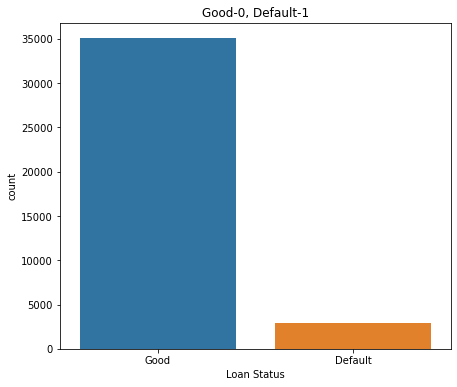

In [10]:
plt.figure(figsize=(7,6))
sns.countplot(df['loan_status'])
plt.title('Good-0, Default-1')
plt.xlabel('Loan Status')
plt.show()

In [11]:
df = pd.concat([df,pd.get_dummies(df['term'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['grade'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['emp_length'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['home_ownership'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['verification_status'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['purpose'])],axis=1)

In [12]:
df = df.drop(columns=['term','grade','emp_length','home_ownership','verification_status','purpose'],axis=1)
df = df.drop(columns=['loan_status'],axis=1)

## 4. Prepping the train test sets <a class="anchor" id="train_test"></a>

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [14]:
X = df.drop(columns=['loan_status_new'],axis=1).values
y = df['loan_status_new'].values

### Stratified split of the dataset

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

In [16]:
y_tr_dist = np.unique(y_train,return_counts=True)
y_test_dist = np.unique(y_test,return_counts=True)
print("Ratio of classes in Train set = ", y_tr_dist[1][1]/y_tr_dist[1][0])
print("Ratio of classes in Test set = ",y_test_dist[1][1]/y_test_dist[1][0])

Ratio of classes in Train set =  0.08324466953228071
Ratio of classes in Test set =  0.08320373250388803


## 5. Implemented Logistic Regression Model <a class="anchor" id="imp_log_reg"></a>

The implemented <a href = https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Logistic_regression/Logistic-Regression-implementation-using-gradient-descent-in-numpy.ipynb> Logistic Regression model </a> uses gradient descent and probably is not the most robust algorithm to minimize the cross entropy cost function. Scikit Learn uses L-BFGS algorithm. L-BFGS will be explored in a future study. The performance of the Logistic regression model suffers due to the above criteria and it fails to predict the Loan "Default" rates.

In [17]:
log1 = logregmodel()
log1.fit(X_train,y_train,alpha=0.01,epoch=10000)

Text(0, 0.5, 'Cost')

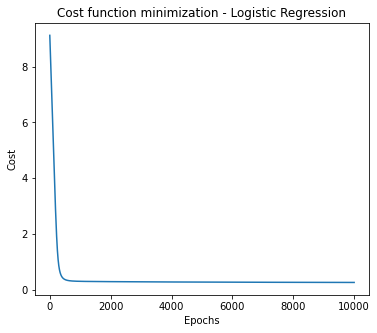

In [18]:
plt.figure(figsize=(6,5))
plt.plot(log1.cost)
plt.title("Cost function minimization - Logistic Regression")
plt.xlabel("Epochs")
plt.ylabel("Cost")

In [19]:
ylog_prob,ylog_class = log1.predict(X_test)

### Confusion Matrix and Classification Report

The confusion matrix shows the real performance of the implemented logistic regression model and it is clear that the True Negatives (Default rate) is zero.

In [20]:
print("Confusion Matrix Logistic Regression\n")
cf_log = confusion_matrix(y_test,ylog_class,normalize='true')
print(cf_log)

Confusion Matrix Logistic Regression

[[9.99913599e-01 8.64005530e-05]
 [1.00000000e+00 0.00000000e+00]]


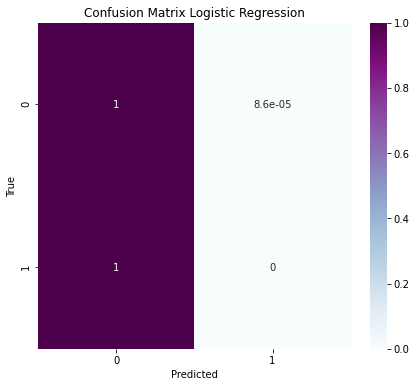

In [21]:
plt.figure(figsize=(7,6))
ax = sns.heatmap(cf_log,annot=True,cmap="BuPu")
ax.set_title("Confusion Matrix Logistic Regression")
ax.set(xlabel = "Predicted",ylabel = "True")
plt.show()

Even though the overall accuracy is good (92%) all the other terms for "Default class" is zero.

In [22]:
print('Classification Report Logistic Regression Model\n')
print(classification_report(y_test,ylog_class))

Classification Report Logistic Regression Model

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11574
           1       0.00      0.00      0.00       963

    accuracy                           0.92     12537
   macro avg       0.46      0.50      0.48     12537
weighted avg       0.85      0.92      0.89     12537



## 6. Neural Network with Traditional Gradient Descent <a class="anchor" id="trad_NN"></a>

The <a href =https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Deep%20Neural%20Network%20Gradient%20Descent/Dense_neural_network_many_layers.ipynb>Feed Forward Neural network implemented using Traditional Gradient Descent </a> was fit to the training dataset.

In [23]:
nn1= dense_NN()

nn1.input_data(X_train,y_train)

# Adding layers using the add_layer function. 2 layers, a tanh and leakyRELU were added.
nn1.add_layer(nodes=200,act_fun='tanh')
nn1.add_layer(100,act_fun='tanh')
nn1.add_layer(100,act_fun='tanh')
nn1.add_layer(100,act_fun='tanh')
# Addition of the final single node sigmoid layer is mandatory for binary classification task
nn1.add_layer(1,act_fun='sigmoid')

# This randomly initializes all the weight matrices and assigns zeros to the bias arrays
nn1.nn_compile()

print("Structure of the neural network")
nn1.summary()

Structure of the neural network
Layer: 1  Node Count: 200  Activation Function: tanh
Layer: 2  Node Count: 100  Activation Function: tanh
Layer: 3  Node Count: 100  Activation Function: tanh
Layer: 4  Node Count: 100  Activation Function: tanh
Layer: 5  Node Count: 1  Activation Function: sigmoid
Total Number of Trainable params: 51601


In [24]:
nn1.fit(alpha=0.6,epochs=4000,verbose=False)

Making predictions on the test set.

In [25]:
ynn1_prob,ynn1_class = nn1.predict(X_test)

Convergence of the cost function.

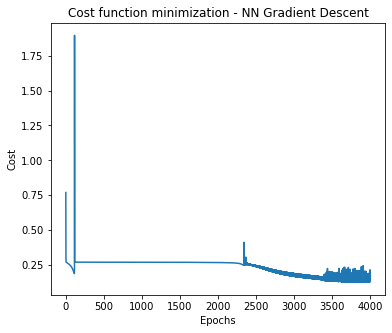

In [26]:
plt.figure(figsize=(6,5))
plt.plot(nn1.cost_list)
plt.title("Cost function minimization - NN Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [27]:
print("Confusion Matrix NN with traditional GD\n")
cf_nn1 = confusion_matrix(y_test,ynn1_class,normalize='true')
print(cf_nn1)

Confusion Matrix NN with traditional GD

[[0.99896319 0.00103681]
 [0.38421599 0.61578401]]


In [28]:
print('Classification Report \n')
print(classification_report(y_test,ynn1_class))

Classification Report 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11574
           1       0.98      0.62      0.76       963

    accuracy                           0.97     12537
   macro avg       0.97      0.81      0.87     12537
weighted avg       0.97      0.97      0.97     12537



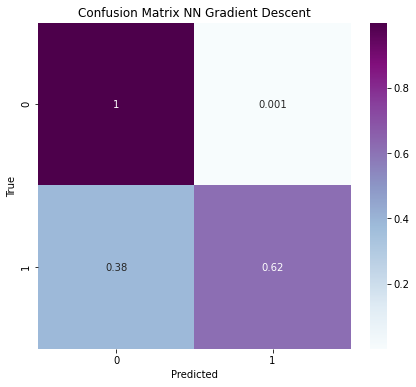

In [29]:
plt.figure(figsize=(7,6))
ax = sns.heatmap(cf_nn1,annot=True,cmap="BuPu")
ax.set_title("Confusion Matrix NN Gradient Descent")
ax.set(xlabel = "Predicted",ylabel = "True")
plt.show()

## 7. Training the Neural Network with mini batch Stochastic Gradient Descent <a class="anchor" id="SGD_NN"></a>

In [30]:
nn3= dense_NN_sgd()
nn3.input_data(X_train,y_train)

# Adding layers using the add_layer function. 2 layers, a tanh and leakyRELU were added.
nn3.add_layer(nodes=200,act_fun='tanh')
nn3.add_layer(nodes=150,act_fun='tanh')
nn3.add_layer(nodes=100,act_fun='tanh')
nn3.add_layer(nodes=100,act_fun='tanh')

# Addition of the final single node sigmoid layer is mandatory for binary classification task
nn3.add_layer(1,act_fun='sigmoid')

# This randomly initializes all the weight matrices and assigns zeros to the bias arrays
nn3.nn_compile()
nn3.summary()

Layer: 1  Node Count: 200  Activation Function: tanh
Layer: 2  Node Count: 150  Activation Function: tanh
Layer: 3  Node Count: 100  Activation Function: tanh
Layer: 4  Node Count: 100  Activation Function: tanh
Layer: 5  Node Count: 1  Activation Function: sigmoid
Total Number of Trainable params: 66651


In [31]:
nn3.fit(alpha=0.8,epochs=500,batch_size=30,call_back=2000,verbose=False)

In [32]:
y_prob_nn3,y_class_nn3 = nn3.predict(X_test)

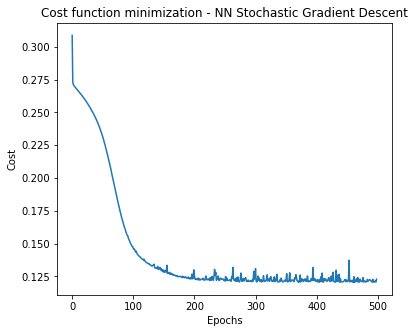

In [33]:
plt.figure(figsize=(6,5))
plt.plot(nn3.cost_list)
plt.title("Cost function minimization - NN Stochastic Gradient Descent")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [34]:
print("Confusion Matrix NN Stochastic Gradient Descent with mini batch \n")
cf_nn3 = confusion_matrix(y_test,y_class_nn3,normalize="true")
print(cf_nn3)

Confusion Matrix NN Stochastic Gradient Descent with mini batch 

[[9.99049594e-01 9.50406083e-04]
 [3.77985462e-01 6.22014538e-01]]


[Text(42.0, 0.5, 'True'), Text(0.5, 33.0, 'Predicted')]

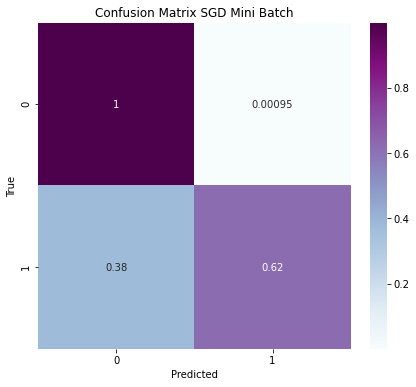

In [35]:
plt.figure(figsize=(7,6))
ax = sns.heatmap(cf_nn3,annot=True,cmap="BuPu")
ax.set_title("Confusion Matrix SGD Mini Batch")
ax.set(xlabel = "Predicted",ylabel = "True")

In [36]:
print('Classification Report \n')
print(classification_report(y_test,y_class_nn3))

Classification Report 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     11574
           1       0.98      0.62      0.76       963

    accuracy                           0.97     12537
   macro avg       0.98      0.81      0.87     12537
weighted avg       0.97      0.97      0.97     12537



## 8. Comparison of Convergence -  Gradient Descent vs. Stochastic Gradient Descent <a class="anchor" id="comparison"></a>

The traditional gradient descent and stochastic gradient descent models seem to produce similar models. The only main difference is the faster convergence of the cost function in SGD. The plot below clearly shows that the traditional GD algorithm gets caught in a local minima and spends a lot of time there before finding another minima (possibly the global minimum). The SGD method get's to the same final minima within the first 500 iterations (epochs)

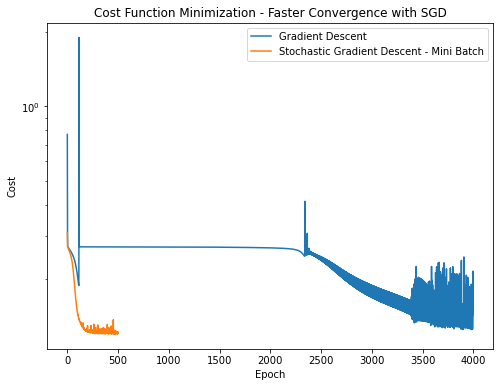

In [37]:
plt.figure(figsize=(8,6))
plt.plot(nn1.cost_list,label = "Gradient Descent")
plt.plot(nn3.cost_list,label = "Stochastic Gradient Descent - Mini Batch")
plt.legend()

plt.title("Cost Function Minimization - Faster Convergence with SGD")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.yscale('log')
plt.show()

## 9. Scikit Learn's Logistic Regression Classifier  <a class="anchor" id="sklearn_logreg"></a>

The LogisticRegression function in Scikit-Learn linear_model module uses Limited BFGS opitmization algorithm which is much more efficient compared to gradient descent in minimizing the cost function. As shown below the performance of the logistic classifier is on par with the implemented neural networks.

In [38]:
from sklearn.linear_model import LogisticRegression
log_sklearn = LogisticRegression(max_iter=2000)
log_sklearn.fit(X_train,y_train)
ylogsk_class = log_sklearn.predict(X_test)
ylog_sk_prob = log_sklearn.predict_proba(X_test)
print("Confusion Matrix Logistic Regression scikit learn\n")
cf_logsk = confusion_matrix(y_test,ylogsk_class,normalize='true')
print(cf_logsk)

Confusion Matrix Logistic Regression scikit learn

[[9.99135994e-01 8.64005530e-04]
 [3.73831776e-01 6.26168224e-01]]


[Text(42.0, 0.5, 'True'), Text(0.5, 33.0, 'Predicted')]

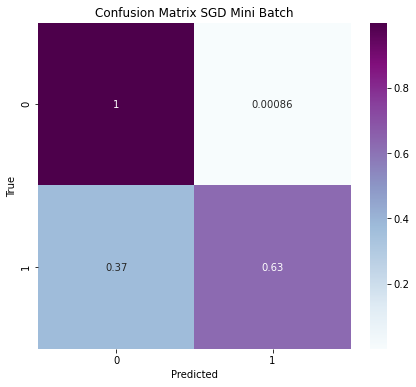

In [39]:
plt.figure(figsize=(7,6))
ax = sns.heatmap(cf_logsk,annot=True,cmap="BuPu")
ax.set_title("Confusion Matrix SGD Mini Batch")
ax.set(xlabel = "Predicted",ylabel = "True")

## 10. The ROC metric <a class="anchor" id="roc"></a>
The <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic#:~:text=A%20receiver%20operating%20characteristic%20curve,its%20discrimination%20threshold%20is%20varied."> Receiver Operator Curve (ROC) </a> and Area under ROC are another set of metrics used for assessing a binary classifier. It plots the _True Positive Rate - Sensitivity_ $\frac {TP}{TP+FN}$ versus the _False Positive Rate -Specificity_ $\frac {FP}{FP + TN} $ by varying the threshold probability. All the algorithms implemented output the actual predicted probabilities in addition to the class labels which are based on a threshold probability of 0.5. Scikit Learn _metrics_ module has _roc_curve_ and _roc_auc_score_ functions for plotting the ROC and calculating the area under it.

In [40]:
from sklearn.metrics import roc_curve,roc_auc_score

In [41]:
#print(roc_auc_score(y_test,ylog_prob))
fpr_log,tpr_log,_= roc_curve(y_test,ylog_prob)
fpr_nn1,tpr_nn1,_ = roc_curve(y_test,ynn1_prob)
fpr_nn3, tpr_nn3, _ = roc_curve(y_test,y_prob_nn3)
fpr_logsk,tpr_logsk,_ = roc_curve(y_test,ylog_sk_prob[:,1])

The ROC curve and the AUC calculations are shown below. As indicated previously, the implemented SGD Neural Network performs the best among all the models with Scikit Learn's Logistic Regression model trailing behind. The implemented Logistic Regression model needs to be improved with the Limited BFGS optimization algorithm.

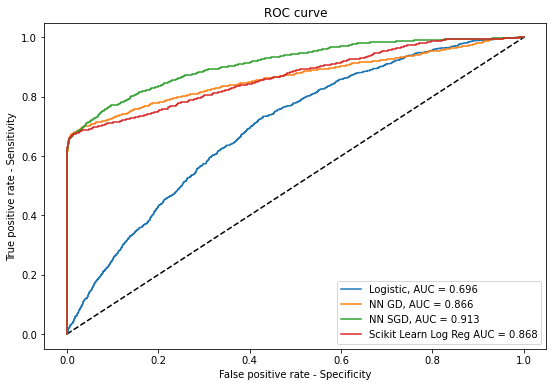

In [42]:
plt.figure(figsize=(9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_log,tpr_log,label="Logistic, AUC = "+str(round(roc_auc_score(y_test,ylog_prob),3)))
plt.plot(fpr_nn1,tpr_nn1,label="NN GD, AUC = "+str(round(roc_auc_score(y_test,ynn1_prob),3)))
plt.plot(fpr_nn3,tpr_nn3,label = "NN SGD, AUC = "+str(round(roc_auc_score(y_test,y_prob_nn3),3)))
plt.plot(fpr_logsk,tpr_logsk,label ="Scikit Learn Log Reg AUC = "+str(round(roc_auc_score(y_test,ylog_sk_prob[:,1]),3)))
plt.xlabel('False positive rate - Specificity')
plt.ylabel('True positive rate - Sensitivity')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()